## 1. Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io, filters, color
from skimage.filters import threshold_otsu, threshold_sauvola
from skimage.morphology import remove_small_objects, binary_opening, binary_closing, disk
from skimage.measure import label, regionprops
import os
from glob import glob
import pandas as pd
from pathlib import Path

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 2. Define Evaluation Metrics

In [2]:
def dice_coefficient(pred, target):
    """
    Calculate Dice Coefficient
    Dice = 2 * |X ∩ Y| / (|X| + |Y|)
    
    Args:
        pred: Predicted binary mask
        target: Ground truth binary mask
    
    Returns:
        Dice coefficient score (0-1)
    """
    pred = pred.astype(bool)
    target = target.astype(bool)
    
    intersection = np.logical_and(pred, target).sum()
    
    if pred.sum() + target.sum() == 0:
        return 1.0  # Both are empty
    
    dice = 2.0 * intersection / (pred.sum() + target.sum())
    return dice


def jaccard_index(pred, target):
    """
    Calculate Jaccard Index (Intersection over Union)
    Jaccard = |X ∩ Y| / |X ∪ Y|
    
    Args:
        pred: Predicted binary mask
        target: Ground truth binary mask
    
    Returns:
        Jaccard index score (0-1)
    """
    pred = pred.astype(bool)
    target = target.astype(bool)
    
    intersection = np.logical_and(pred, target).sum()
    union = np.logical_or(pred, target).sum()
    
    if union == 0:
        return 1.0  # Both are empty
    
    jaccard = intersection / union
    return jaccard


def print_metrics(dice, jaccard, method_name):
    """
    Print evaluation metrics
    """
    print(f"\n{method_name} Results:")
    print(f"  Dice Coefficient: {dice:.4f}")
    print(f"  Jaccard Index:    {jaccard:.4f}")

## 3. Segmentation Methods

In [3]:
def preprocess_image(image):
    """
    Preprocess MRI image
    - Convert to grayscale if needed
    - Normalize intensity
    """
    # Convert to grayscale if RGB
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
    
    # Normalize to [0, 1]
    image = image.astype(np.float64)
    image = (image - image.min()) / (image.max() - image.min() + 1e-8)
    
    return image


def otsu_segmentation(image, apply_morphology=True):
    """
    Global Otsu Thresholding
    
    Otsu's method finds the optimal global threshold by minimizing 
    intra-class variance (or equivalently, maximizing inter-class variance)
    
    Args:
        image: Input grayscale image (normalized)
        apply_morphology: Apply morphological operations for cleanup
    
    Returns:
        Binary segmentation mask
    """
    # Calculate Otsu threshold
    thresh = threshold_otsu(image)
    
    # Apply threshold
    binary = image > thresh
    
    if apply_morphology:
        # Remove small objects (noise)
        binary = remove_small_objects(binary, min_size=50)
        
        # Morphological closing to fill holes
        binary = binary_closing(binary, disk(3))
        
        # Morphological opening to remove small protrusions
        binary = binary_opening(binary, disk(2))
    
    return binary.astype(np.uint8)


def sauvola_segmentation(image, window_size=25, k=0.2, apply_morphology=True):
    """
    Sauvola Adaptive Thresholding
    
    Sauvola is a local adaptive thresholding method that computes a threshold 
    for each pixel based on local mean and standard deviation.
    
    Threshold(x,y) = mean(x,y) * [1 + k * (std(x,y)/R - 1)]
    where R is the dynamic range of std (typically 128 for grayscale)
    
    Args:
        image: Input grayscale image (normalized)
        window_size: Size of local window (odd number)
        k: Sensitivity parameter (0.2-0.5 typically)
        apply_morphology: Apply morphological operations for cleanup
    
    Returns:
        Binary segmentation mask
    """
    # Calculate Sauvola threshold
    thresh_sauvola = threshold_sauvola(image, window_size=window_size, k=k)
    
    # Apply threshold
    binary = image > thresh_sauvola
    
    if apply_morphology:
        # Remove small objects (noise)
        binary = remove_small_objects(binary, min_size=50)
        
        # Morphological closing to fill holes
        binary = binary_closing(binary, disk(3))
        
        # Morphological opening to remove small protrusions
        binary = binary_opening(binary, disk(2))
    
    return binary.astype(np.uint8)

## 4. Load and Prepare Dataset

### Setup Kaggle Dataset Download

**Option 1: Download via Kaggle API (Recommended)**

1. Install Kaggle API:
   ```bash
   pip install kaggle
   ```

2. Get your Kaggle API credentials:
   - Go to https://www.kaggle.com/account
   - Scroll to "API" section and click "Create New API Token"
   - This downloads `kaggle.json` file

3. Place the `kaggle.json` file:
   - **Windows**: `C:\Users\<YourUsername>\.kaggle\kaggle.json`
   - **Linux/Mac**: `~/.kaggle/kaggle.json`

4. Run the download command in the next cell

**Option 2: Manual Download**
- Download from: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
- Extract to `./brain_mri_dataset` folder

In [4]:
# Download dataset from Kaggle (run this once)
import os
import zipfile

# Create dataset directory
os.makedirs('./brain_mri_dataset', exist_ok=True)

# Download using Kaggle API
# Make sure you have kaggle.json configured first (see instructions above)
try:
    import kaggle
    print("Downloading dataset from Kaggle...")
    kaggle.api.dataset_download_files(
        'nikhilroxtomar/brain-tumor-segmentation',
        path='./brain_mri_dataset',
        unzip=True
    )
    print("✓ Dataset downloaded and extracted successfully!")
except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("\nAlternative: Download manually from:")
    print("https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation")
    print("Extract to './brain_mri_dataset' folder")

Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
✓ Dataset downloaded and extracted successfully!


In [5]:
# Dataset configuration
DATASET_PATH = "./brain_mri_dataset"  # Path to your dataset

def load_dataset(dataset_path, num_samples=None):
    """
    Load MRI images and their corresponding masks
    Supports two structures:
    1. Separate folders: dataset/images/ and dataset/masks/
    2. Paired files: dataset/*/image.tif and dataset/*/image_mask.tif
    
    Args:
        dataset_path: Path to dataset directory
        num_samples: Number of samples to load (None = load all)
    
    Returns:
        List of (image, mask) tuples
    """
    data = []
    
    # Check if path exists
    if not os.path.exists(dataset_path):
        print(f"Error: Dataset path '{dataset_path}' does not exist!")
        print("Please update DATASET_PATH and ensure the dataset is available.")
        return []
    
    # Check for separate images and masks folders
    images_folder = os.path.join(dataset_path, "images")
    masks_folder = os.path.join(dataset_path, "masks")
    
    if os.path.exists(images_folder) and os.path.exists(masks_folder):
        print(f"Found separate 'images' and 'masks' folders")
        
        # Find all image files (support multiple formats)
        image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.tif', '*.tiff', '*.bmp']
        image_files = []
        for ext in image_extensions:
            image_files.extend(glob(os.path.join(images_folder, ext)))
        
        image_files = sorted(image_files)
        if num_samples is not None:
            image_files = image_files[:num_samples]
        
        if not image_files:
            print("Error: No image files found in images folder.")
            print("Please ensure your dataset contains image files.")
            return []
        
        print(f"Found {len(image_files)} images")
        
        for img_path in image_files:
            # Load image
            image = io.imread(img_path)
            
            # Find corresponding mask (same filename in masks folder)
            img_filename = os.path.basename(img_path)
            
            # Try exact same name first
            mask_path = os.path.join(masks_folder, img_filename)
            
            # If not found, try common mask naming patterns
            if not os.path.exists(mask_path):
                base_name = os.path.splitext(img_filename)[0]
                for ext in ['.png', '.jpg', '.tif', '.tiff']:
                    mask_path = os.path.join(masks_folder, base_name + ext)
                    if os.path.exists(mask_path):
                        break
            
            if os.path.exists(mask_path):
                mask = io.imread(mask_path)
                # Convert mask to binary
                if len(mask.shape) == 3:
                    mask = color.rgb2gray(mask)
                mask = (mask > 0).astype(np.uint8)
                print(f"✓ Loaded: {img_filename} + mask")
            else:
                print(f"⚠ No mask found for: {img_filename}")
                # Create empty mask if not found
                mask = np.zeros(image.shape[:2], dtype=np.uint8)
            
            data.append((image, mask))
    
    else:
        # Try original pattern (images with _mask suffix in subfolders)
        print("Looking for image-mask pairs in subfolders...")
        image_files = glob(os.path.join(dataset_path, "*/*[!mask].tif"))
        
        if not image_files:
            # Try alternative patterns
            image_files = glob(os.path.join(dataset_path, "*.tif"))
            image_files = [f for f in image_files if 'mask' not in f]
        
        if num_samples is not None:
            image_files = image_files[:num_samples]
        
        if not image_files:
            print("Error: No image files found in the dataset.")
            print("Please ensure your dataset is properly structured.")
            return []
        
        for img_path in image_files:
            # Load image
            image = io.imread(img_path)
            
            # Find corresponding mask
            mask_path = img_path.replace('.tif', '_mask.tif')
            
            if os.path.exists(mask_path):
                mask = io.imread(mask_path)
                # Convert mask to binary
                if len(mask.shape) == 3:
                    mask = color.rgb2gray(mask)
                mask = (mask > 0).astype(np.uint8)
            else:
                # Create dummy mask if not found
                mask = np.zeros(image.shape[:2], dtype=np.uint8)
            
            data.append((image, mask))
    
    if data:
        print(f"\n✓ Successfully loaded {len(data)} image-mask pairs")
    else:
        print("\nError: No data could be loaded. Please check your dataset path and structure.")
    
    return data


In [6]:
# Load entire dataset
mri_data = load_dataset(DATASET_PATH)
print(f"\nTotal samples: {len(mri_data)}")

Found separate 'images' and 'masks' folders
Found 3064 images
✓ Loaded: 1.png + mask
✓ Loaded: 10.png + mask
✓ Loaded: 100.png + mask
✓ Loaded: 1000.png + mask
✓ Loaded: 1001.png + mask
✓ Loaded: 1002.png + mask
✓ Loaded: 1003.png + mask
✓ Loaded: 1004.png + mask
✓ Loaded: 1005.png + mask
✓ Loaded: 1006.png + mask
✓ Loaded: 1007.png + mask
✓ Loaded: 1008.png + mask
✓ Loaded: 1009.png + mask
✓ Loaded: 101.png + mask
✓ Loaded: 1010.png + mask
✓ Loaded: 1011.png + mask
✓ Loaded: 1012.png + mask
✓ Loaded: 1013.png + mask
✓ Loaded: 1014.png + mask
✓ Loaded: 1015.png + mask
✓ Loaded: 1016.png + mask
✓ Loaded: 1017.png + mask
✓ Loaded: 1018.png + mask
✓ Loaded: 1019.png + mask
✓ Loaded: 102.png + mask
✓ Loaded: 1020.png + mask
✓ Loaded: 1021.png + mask
✓ Loaded: 1022.png + mask
✓ Loaded: 1023.png + mask
✓ Loaded: 1024.png + mask
✓ Loaded: 1025.png + mask
✓ Loaded: 1026.png + mask
✓ Loaded: 1027.png + mask
✓ Loaded: 1028.png + mask
✓ Loaded: 1029.png + mask
✓ Loaded: 103.png + mask
✓ Loaded: 1

## 5. Visualize Sample Data

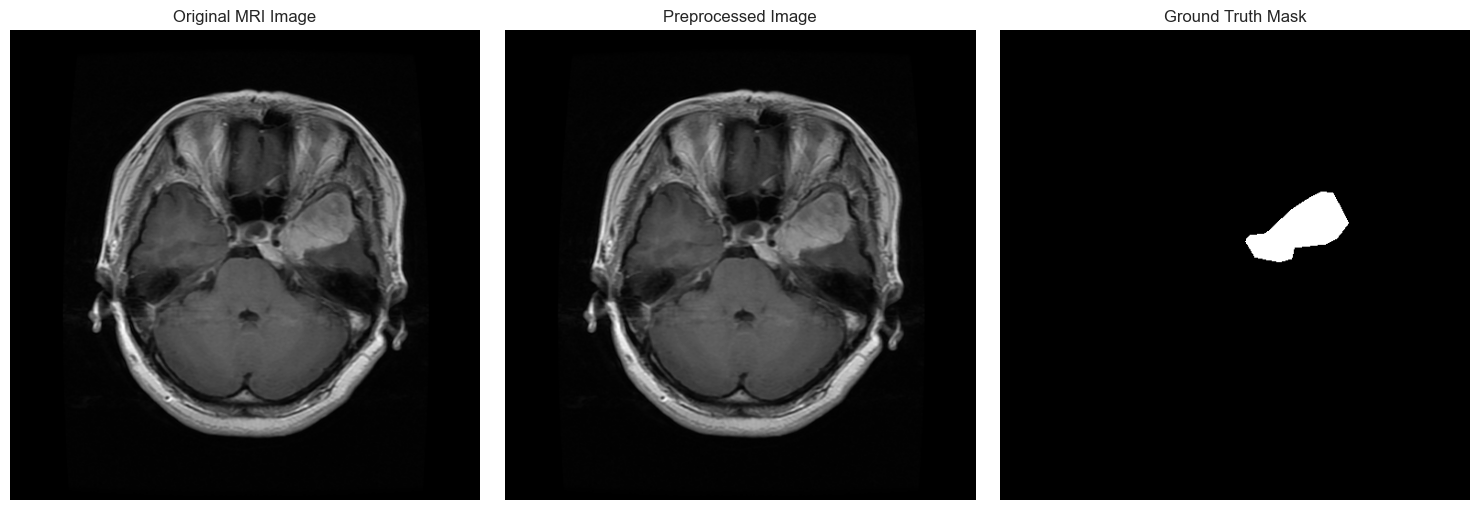

In [7]:
# Display first sample
if len(mri_data) > 0:
    sample_img, sample_mask = mri_data[0]
    sample_img_processed = preprocess_image(sample_img)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(sample_img, cmap='gray')
    axes[0].set_title('Original MRI Image', fontsize=12)
    axes[0].axis('off')
    
    axes[1].imshow(sample_img_processed, cmap='gray')
    axes[1].set_title('Preprocessed Image', fontsize=12)
    axes[1].axis('off')
    
    axes[2].imshow(sample_mask, cmap='gray')
    axes[2].set_title('Ground Truth Mask', fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

## 6. Apply Segmentation Methods and Compare

In [8]:
def compare_methods(image, ground_truth_mask, visualize=True):
    """
    Compare Otsu and Sauvola segmentation methods
    
    Args:
        image: Input MRI image
        ground_truth_mask: Ground truth segmentation
        visualize: Whether to display results
    
    Returns:
        Dictionary containing results and metrics
    """
    # Preprocess image
    img_processed = preprocess_image(image)
    
    # Apply Otsu thresholding
    otsu_mask = otsu_segmentation(img_processed)
    
    # Apply Sauvola thresholding
    sauvola_mask = sauvola_segmentation(img_processed, window_size=25, k=0.2)
    
    # Calculate metrics for Otsu
    otsu_dice = dice_coefficient(otsu_mask, ground_truth_mask)
    otsu_jaccard = jaccard_index(otsu_mask, ground_truth_mask)
    
    # Calculate metrics for Sauvola
    sauvola_dice = dice_coefficient(sauvola_mask, ground_truth_mask)
    sauvola_jaccard = jaccard_index(sauvola_mask, ground_truth_mask)
    
    if visualize:
        # Visualization
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Row 1: Original, Ground Truth, Comparison
        axes[0, 0].imshow(img_processed, cmap='gray')
        axes[0, 0].set_title('Original MRI Image', fontsize=14, fontweight='bold')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(ground_truth_mask, cmap='gray')
        axes[0, 1].set_title('Ground Truth Mask', fontsize=14, fontweight='bold')
        axes[0, 1].axis('off')
        
        # Overlay comparison
        overlay = np.zeros((*img_processed.shape, 3))
        overlay[:, :, 0] = ground_truth_mask  # Red: Ground truth
        overlay[:, :, 1] = otsu_mask  # Green: Otsu
        overlay[:, :, 2] = sauvola_mask  # Blue: Sauvola
        axes[0, 2].imshow(overlay)
        axes[0, 2].set_title('Overlay (R:GT, G:Otsu, B:Sauvola)', fontsize=14, fontweight='bold')
        axes[0, 2].axis('off')
        
        # Row 2: Otsu, Sauvola, Metrics
        axes[1, 0].imshow(otsu_mask, cmap='gray')
        axes[1, 0].set_title(f'Otsu Segmentation\nDice: {otsu_dice:.4f}, Jaccard: {otsu_jaccard:.4f}', 
                            fontsize=12, fontweight='bold')
        axes[1, 0].axis('off')
        
        axes[1, 1].imshow(sauvola_mask, cmap='gray')
        axes[1, 1].set_title(f'Sauvola Segmentation\nDice: {sauvola_dice:.4f}, Jaccard: {sauvola_jaccard:.4f}', 
                            fontsize=12, fontweight='bold')
        axes[1, 1].axis('off')
        
        # Metrics comparison bar chart
        methods = ['Otsu', 'Sauvola']
        dice_scores = [otsu_dice, sauvola_dice]
        jaccard_scores = [otsu_jaccard, sauvola_jaccard]
        
        x = np.arange(len(methods))
        width = 0.35
        
        bars1 = axes[1, 2].bar(x - width/2, dice_scores, width, label='Dice', color='steelblue')
        bars2 = axes[1, 2].bar(x + width/2, jaccard_scores, width, label='Jaccard', color='coral')
        
        axes[1, 2].set_ylabel('Score', fontsize=12)
        axes[1, 2].set_title('Performance Comparison', fontsize=14, fontweight='bold')
        axes[1, 2].set_xticks(x)
        axes[1, 2].set_xticklabels(methods)
        axes[1, 2].legend()
        axes[1, 2].set_ylim([0, 1])
        axes[1, 2].grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                axes[1, 2].text(bar.get_x() + bar.get_width()/2., height,
                              f'{height:.3f}',
                              ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()
    
    return {
        'otsu_mask': otsu_mask,
        'sauvola_mask': sauvola_mask,
        'otsu_dice': otsu_dice,
        'otsu_jaccard': otsu_jaccard,
        'sauvola_dice': sauvola_dice,
        'sauvola_jaccard': sauvola_jaccard
    }

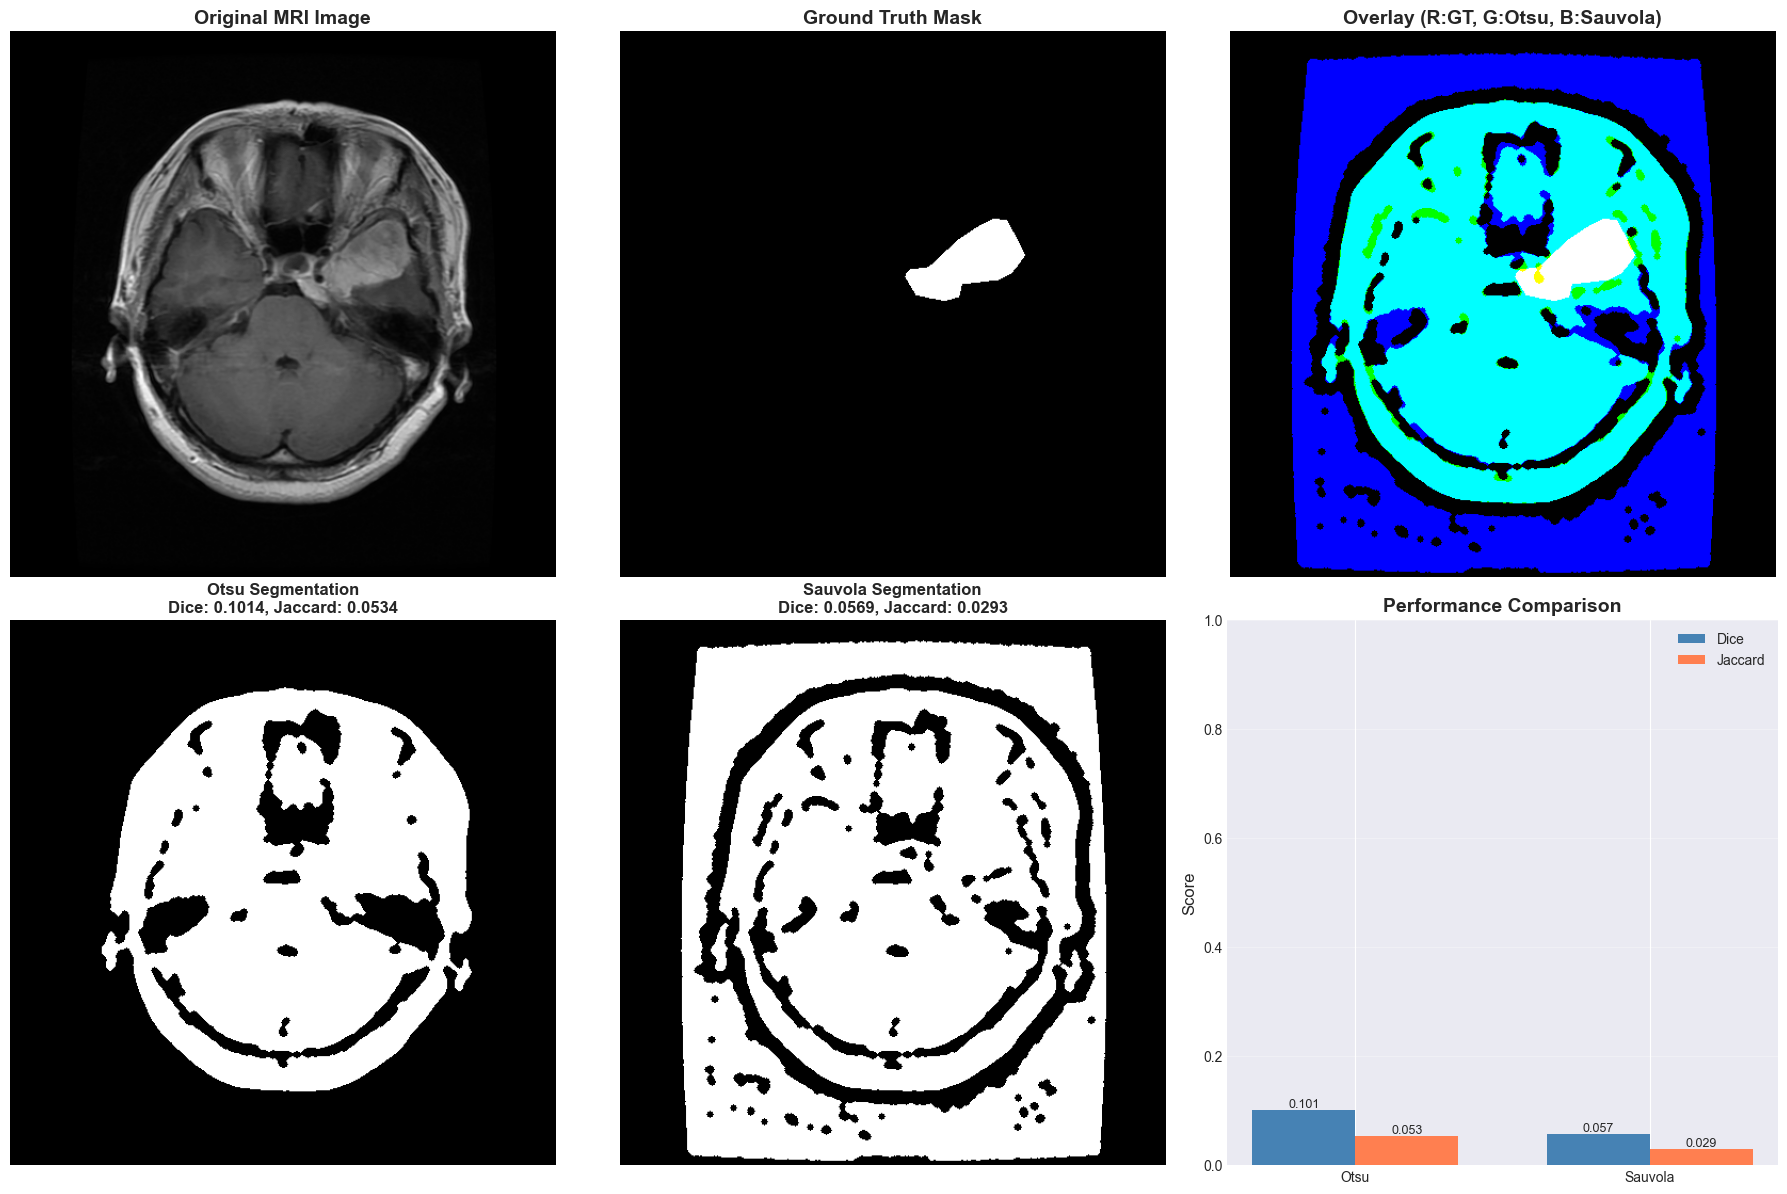


SEGMENTATION RESULTS - SAMPLE 1

Global Otsu Results:
  Dice Coefficient: 0.1014
  Jaccard Index:    0.0534

Sauvola Adaptive Results:
  Dice Coefficient: 0.0569
  Jaccard Index:    0.0293


In [9]:
# Compare methods on first sample
if len(mri_data) > 0:
    sample_img, sample_mask = mri_data[0]
    results = compare_methods(sample_img, sample_mask, visualize=True)
    
    print("\n" + "="*50)
    print("SEGMENTATION RESULTS - SAMPLE 1")
    print("="*50)
    print_metrics(results['otsu_dice'], results['otsu_jaccard'], "Global Otsu")
    print_metrics(results['sauvola_dice'], results['sauvola_jaccard'], "Sauvola Adaptive")
    print("="*50)

## 7. Batch Evaluation on Multiple Samples

In [10]:
def evaluate_all_samples(mri_data):
    """
    Evaluate both methods on all samples and compute average metrics
    """
    results_list = []
    
    print("Evaluating all samples...\n")
    
    for idx, (image, mask) in enumerate(mri_data):
        print(f"Processing sample {idx + 1}/{len(mri_data)}...", end=' ')
        
        result = compare_methods(image, mask, visualize=False)
        results_list.append(result)
        
        print(f"Otsu Dice: {result['otsu_dice']:.4f}, Sauvola Dice: {result['sauvola_dice']:.4f}")
    
    # Calculate average metrics
    avg_otsu_dice = np.mean([r['otsu_dice'] for r in results_list])
    avg_otsu_jaccard = np.mean([r['otsu_jaccard'] for r in results_list])
    avg_sauvola_dice = np.mean([r['sauvola_dice'] for r in results_list])
    avg_sauvola_jaccard = np.mean([r['sauvola_jaccard'] for r in results_list])
    
    # Calculate standard deviations
    std_otsu_dice = np.std([r['otsu_dice'] for r in results_list])
    std_otsu_jaccard = np.std([r['otsu_jaccard'] for r in results_list])
    std_sauvola_dice = np.std([r['sauvola_dice'] for r in results_list])
    std_sauvola_jaccard = np.std([r['sauvola_jaccard'] for r in results_list])
    
    return {
        'results_list': results_list,
        'avg_otsu_dice': avg_otsu_dice,
        'avg_otsu_jaccard': avg_otsu_jaccard,
        'avg_sauvola_dice': avg_sauvola_dice,
        'avg_sauvola_jaccard': avg_sauvola_jaccard,
        'std_otsu_dice': std_otsu_dice,
        'std_otsu_jaccard': std_otsu_jaccard,
        'std_sauvola_dice': std_sauvola_dice,
        'std_sauvola_jaccard': std_sauvola_jaccard
    }

In [11]:
# Evaluate all samples
if len(mri_data) > 0:
    evaluation_results = evaluate_all_samples(mri_data)

Evaluating all samples...

Processing sample 1/3064... Otsu Dice: 0.1014, Sauvola Dice: 0.0569
Processing sample 2/3064... Otsu Dice: 0.0832, Sauvola Dice: 0.0455
Processing sample 3/3064... Otsu Dice: 0.0505, Sauvola Dice: 0.0327
Processing sample 4/3064... Otsu Dice: 0.0267, Sauvola Dice: 0.0157
Processing sample 5/3064... Otsu Dice: 0.0293, Sauvola Dice: 0.0175
Processing sample 6/3064... Otsu Dice: 0.0234, Sauvola Dice: 0.0137
Processing sample 7/3064... Otsu Dice: 0.0321, Sauvola Dice: 0.0211
Processing sample 8/3064... Otsu Dice: 0.0265, Sauvola Dice: 0.0179
Processing sample 9/3064... Otsu Dice: 0.0212, Sauvola Dice: 0.0148
Processing sample 10/3064... Otsu Dice: 0.0281, Sauvola Dice: 0.0199
Processing sample 11/3064... Otsu Dice: 0.0254, Sauvola Dice: 0.0190
Processing sample 12/3064... Otsu Dice: 0.0367, Sauvola Dice: 0.0276
Processing sample 13/3064... Otsu Dice: 0.0259, Sauvola Dice: 0.0195
Processing sample 14/3064... Otsu Dice: 0.0628, Sauvola Dice: 0.0432
Processing sampl

## 8. Results Summary and Visualization

In [12]:
# Display summary statistics
if len(mri_data) > 0:
    print("\n" + "="*70)
    print("OVERALL PERFORMANCE SUMMARY")
    print("="*70)
    print(f"\nNumber of samples evaluated: {len(mri_data)}")
    print("\n" + "-"*70)
    print("GLOBAL OTSU THRESHOLDING")
    print("-"*70)
    print(f"  Average Dice Coefficient: {evaluation_results['avg_otsu_dice']:.4f} ± {evaluation_results['std_otsu_dice']:.4f}")
    print(f"  Average Jaccard Index:    {evaluation_results['avg_otsu_jaccard']:.4f} ± {evaluation_results['std_otsu_jaccard']:.4f}")
    
    print("\n" + "-"*70)
    print("SAUVOLA ADAPTIVE THRESHOLDING")
    print("-"*70)
    print(f"  Average Dice Coefficient: {evaluation_results['avg_sauvola_dice']:.4f} ± {evaluation_results['std_sauvola_dice']:.4f}")
    print(f"  Average Jaccard Index:    {evaluation_results['avg_sauvola_jaccard']:.4f} ± {evaluation_results['std_sauvola_jaccard']:.4f}")
    print("="*70)
    
    # Determine better method
    print("\nCOMPARISON:")
    if evaluation_results['avg_otsu_dice'] > evaluation_results['avg_sauvola_dice']:
        diff = evaluation_results['avg_otsu_dice'] - evaluation_results['avg_sauvola_dice']
        print(f"  Global Otsu performs better by {diff:.4f} Dice points")
    else:
        diff = evaluation_results['avg_sauvola_dice'] - evaluation_results['avg_otsu_dice']
        print(f"  Sauvola Adaptive performs better by {diff:.4f} Dice points")


OVERALL PERFORMANCE SUMMARY

Number of samples evaluated: 3064

----------------------------------------------------------------------
GLOBAL OTSU THRESHOLDING
----------------------------------------------------------------------
  Average Dice Coefficient: 0.0694 ± 0.0572
  Average Jaccard Index:    0.0369 ± 0.0320

----------------------------------------------------------------------
SAUVOLA ADAPTIVE THRESHOLDING
----------------------------------------------------------------------
  Average Dice Coefficient: 0.0445 ± 0.0368
  Average Jaccard Index:    0.0231 ± 0.0198

COMPARISON:
  Global Otsu performs better by 0.0249 Dice points


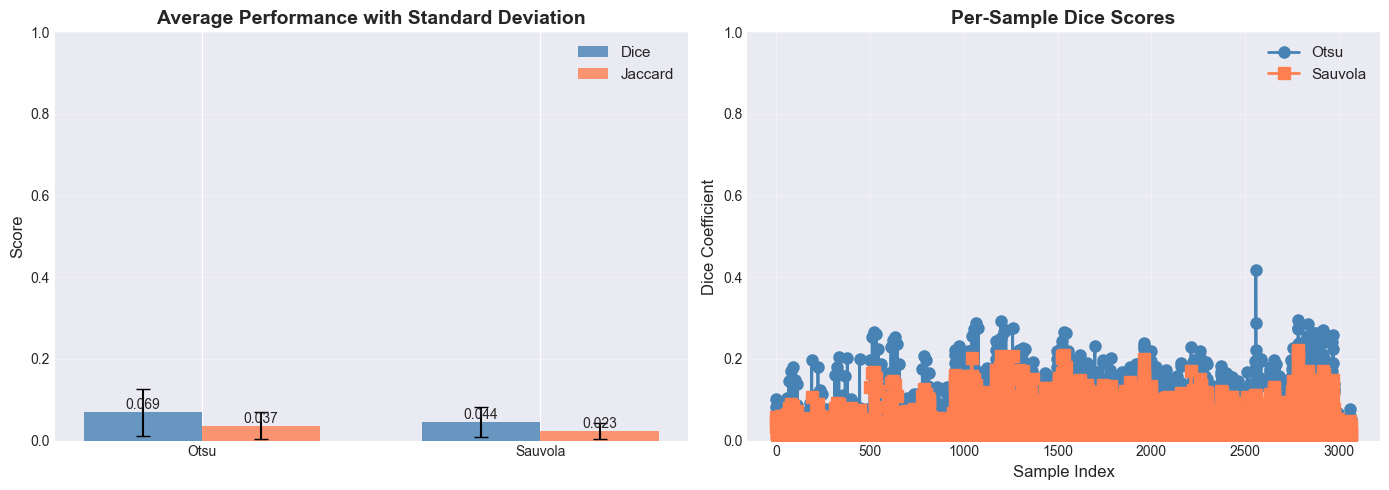

In [13]:
# Create comprehensive comparison visualization
if len(mri_data) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Bar chart with error bars
    methods = ['Otsu', 'Sauvola']
    dice_means = [evaluation_results['avg_otsu_dice'], evaluation_results['avg_sauvola_dice']]
    dice_stds = [evaluation_results['std_otsu_dice'], evaluation_results['std_sauvola_dice']]
    jaccard_means = [evaluation_results['avg_otsu_jaccard'], evaluation_results['avg_sauvola_jaccard']]
    jaccard_stds = [evaluation_results['std_otsu_jaccard'], evaluation_results['std_sauvola_jaccard']]
    
    x = np.arange(len(methods))
    width = 0.35
    
    bars1 = axes[0].bar(x - width/2, dice_means, width, yerr=dice_stds, 
                           label='Dice', capsize=5, color='steelblue', alpha=0.8)
    bars2 = axes[0].bar(x + width/2, jaccard_means, width, yerr=jaccard_stds,
                           label='Jaccard', capsize=5, color='coral', alpha=0.8)
    
    axes[0].set_ylabel('Score', fontsize=12)
    axes[0].set_title('Average Performance with Standard Deviation', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(methods)
    axes[0].legend(fontsize=11)
    axes[0].set_ylim([0, 1])
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height,
                          f'{height:.3f}',
                          ha='center', va='bottom', fontsize=10)
    
    # Plot 2: Line plot showing per-sample Dice scores
    sample_indices = list(range(1, len(mri_data) + 1))
    otsu_dice_scores = [r['otsu_dice'] for r in evaluation_results['results_list']]
    sauvola_dice_scores = [r['sauvola_dice'] for r in evaluation_results['results_list']]
    
    axes[1].plot(sample_indices, otsu_dice_scores, 'o-', label='Otsu', 
                    linewidth=2, markersize=8, color='steelblue')
    axes[1].plot(sample_indices, sauvola_dice_scores, 's-', label='Sauvola', 
                    linewidth=2, markersize=8, color='coral')
    axes[1].set_xlabel('Sample Index', fontsize=12)
    axes[1].set_ylabel('Dice Coefficient', fontsize=12)
    axes[1].set_title('Per-Sample Dice Scores', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()


## 9. Create Results DataFrame

In [14]:
# Create detailed results table
if len(mri_data) > 0:
    results_df = pd.DataFrame({
        'Sample': range(1, len(mri_data) + 1),
        'Otsu_Dice': [r['otsu_dice'] for r in evaluation_results['results_list']],
        'Otsu_Jaccard': [r['otsu_jaccard'] for r in evaluation_results['results_list']],
        'Sauvola_Dice': [r['sauvola_dice'] for r in evaluation_results['results_list']],
        'Sauvola_Jaccard': [r['sauvola_jaccard'] for r in evaluation_results['results_list']]
    })
    
    # Add difference columns
    results_df['Dice_Diff'] = results_df['Sauvola_Dice'] - results_df['Otsu_Dice']
    results_df['Jaccard_Diff'] = results_df['Sauvola_Jaccard'] - results_df['Otsu_Jaccard']
    
    print("\nDetailed Results per Sample:")
    print(results_df.to_string(index=False))
    
    # Summary statistics
    print("\n\nSummary Statistics:")
    print(results_df.describe())


Detailed Results per Sample:
 Sample  Otsu_Dice  Otsu_Jaccard  Sauvola_Dice  Sauvola_Jaccard  Dice_Diff  Jaccard_Diff
      1   0.101403      0.053409      0.056899         0.029283  -0.044504     -0.024127
      2   0.083220      0.043417      0.045494         0.023276  -0.037726     -0.020140
      3   0.050471      0.025889      0.032720         0.016632  -0.017750     -0.009256
      4   0.026652      0.013506      0.015663         0.007894  -0.010989     -0.005613
      5   0.029320      0.014878      0.017480         0.008817  -0.011840     -0.006061
      6   0.023377      0.011827      0.013683         0.006889  -0.009695     -0.004938
      7   0.032090      0.016307      0.021145         0.010686  -0.010945     -0.005621
      8   0.026511      0.013434      0.017946         0.009054  -0.008565     -0.004379
      9   0.021171      0.010699      0.014785         0.007448  -0.006386     -0.003251
     10   0.028106      0.014253      0.019920         0.010060  -0.008186     -

## 10. Key Insights: Global vs Adaptive Thresholding

### Global Otsu Thresholding:
**Advantages:**
- Simple and fast computation
- Works well when there's clear bimodal intensity distribution
- No parameters to tune

**Disadvantages:**
- Single threshold for entire image
- Sensitive to illumination variations
- Struggles with images having weak contrast

### Sauvola Adaptive Thresholding:
**Advantages:**
- Adapts to local intensity variations
- Better handling of non-uniform illumination
- More robust to local contrast variations

**Disadvantages:**
- More computationally expensive
- Requires parameter tuning (window size, k)
- May introduce more noise in uniform regions


## 11. Conclusions

This notebook demonstrated:

1. **Implementation** of Global Otsu and Sauvola Adaptive thresholding for brain MRI tumor segmentation
2. **Quantitative evaluation** using Dice coefficient and Jaccard index metrics
3. **Comparative analysis** showing strengths and weaknesses of each method

### Key Takeaways:
- Both methods have their place in medical image segmentation
- Choice depends on image characteristics and application requirements
- Proper preprocessing and post-processing are crucial for both methods
